In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_DIR = "Video Analysis Data/"
OUTPUT_FILE = "processed_video_data.csv"

L_full = 27.35  # cm
L_map = {
    "full": L_full,
    "3/4": 0.75 * L_full,
    "1/2": 0.5 * L_full
}


In [3]:
# ---------------------------
# Metadata table
# ---------------------------
# Construct manually from your given mapping
metadata = [
    # video, keep, trial, mass, L_label
    (1,  "no",  None, None, "full"),
    (2,  "yes", 1, 998, "full"),
    (3,  "yes", 2, 998, "full"),
    (4,  "yes", 3, 998, "full"),
    (5,  "yes", 1, 495, "full"),
    (6,  "yes", 2, 495, "full"),
    (7,  "yes", 3, 495, "full"),
    (8,  "yes", 1, 398, "full"),
    (9,  "yes", 2, 398, "full"),
    (10, "yes", 3, 398, "full"),
    (11, "yes", 1, 200, "full"),
    (12, "yes", 2, 200, "full"),
    (13, "yes", 3, 200, "full"),
    (14, "yes", 1, 50,  "full"),
    (15, "yes", 2, 50,  "full"),
    (16, "yes", 3, 50,  "full"),
    (17, "no",  None, None, "3/4"),
    (18, "yes", 1, 998, "3/4"),
    (19, "yes", 2, 998, "3/4"),
    (20, "yes", 3, 998, "3/4"),
    (21, "yes", 1, 500, "3/4"),
    (22, "yes", 2, 500, "3/4"),
    (23, "yes", 3, 500, "3/4"),
    (24, "yes", 1, 398, "3/4"),
    (25, "yes", 2, 398, "3/4"),
    (26, "yes", 3, 398, "3/4"),
    (27, "yes", 1, 200, "3/4"),
    (28, "yes", 2, 200, "3/4"),
    (29, "yes", 3, 200, "3/4"),
    (30, "yes", 1, 50,  "3/4"),
    (31, "yes", 2, 50,  "3/4"),
    (32, "yes", 3, 50,  "3/4"),
    (33, "yes", 1, 50,  "1/2"),
    (34, "yes", 2, 50,  "1/2"),
    (35, "yes", 3, 50,  "1/2"),
    (36, "yes", 1, 998, "1/2"),
    (37, "yes", 2, 998, "1/2"),
    (38, "no",  None, None, "1/2"),
    (39, "yes", 3, 998, "1/2"),
    (40, "yes", 1, 500, "1/2"),
    (41, "yes", 2, 500, "1/2"),
    (42, "yes", 3, 500, "1/2"),
    (43, "yes", 1, 398, "1/2"),
    (44, "yes", 2, 398, "1/2"),
    (45, "yes", 3, 398, "1/2"),
    (46, "yes", 1, 200, "1/2"),
    (47, "yes", 2, 200, "1/2"),
    (48, "yes", 3, 200, "1/2"),
]

metadata_df = pd.DataFrame(metadata, columns=["video", "keep", "trial", "mass", "L_label"])

In [4]:
mass_map = {
    998: "1000",
    495: "500",
    500: "500",
    398: "400",
    200: "200",
    50: "50"
}

metadata_df["mass_label"] = metadata_df["mass"].map(mass_map)

# ---------------------------
# Read data into dictionary
# ---------------------------
def read_video_file(video_num, trial, mass_label, L_label):
    filename = f"Vid_{video_num}.txt"
    filepath = os.path.join(DATA_DIR, filename)
#     print(filepath)

    if not os.path.exists(filepath):
        return None

    df = pd.read_csv(filepath, skiprows=2, names=["t", "x", "y"])
    df["trial"] = trial
    df["mass_label"] = mass_label
    df["video"] = video_num
    df["L_label"] = L_label
    return df


# Initialize dictionaries
L_full = {}
L_three_four = {}
L_half = {}

# Process files
for L_choice, L_dict in [("full", L_full), ("3/4", L_three_four), ("1/2", L_half)]:
    subset = metadata_df[(metadata_df["L_label"] == L_choice) & (metadata_df["keep"] == "yes")]

    for mass_label in sorted(subset["mass_label"].dropna().unique()):
        dfs = []
        for _, row in subset[subset["mass_label"] == mass_label].iterrows():
            df = read_video_file(row["video"], row["trial"], row["mass_label"], row["L_label"])
            if df is not None:
                dfs.append(df)

        if dfs:
            L_dict[f"m = {mass_label}"] = pd.concat(dfs, ignore_index=True)

print("Keys in L_full:", L_full.keys())
print("Shape of df for m=1000 in L_full:", L_full["m = 1000"].shape)

Keys in L_full: dict_keys(['m = 1000', 'm = 200', 'm = 400', 'm = 50', 'm = 500'])
Shape of df for m=1000 in L_full: (3663, 7)


In [5]:
def calculate_period_fft(df, axis="x", start_time=0, massk = 0, tri = 0, df_name = "Whatt", plot=False):
    # Preprocess
    df_proc = preprocess_time_series(df, axis=axis, start_time=start_time)
    if df_proc is None or df_proc.empty:
        return None

    t = df_proc["t"].values
    y = df_proc[axis].values

    dt = np.mean(np.diff(t))
    fs = 1.0 / dt

    # FFT
    N = len(y)
    yf = np.fft.fft(y)
    xf = np.fft.fftfreq(N, dt)

    idx = xf > 0
    xf_pos = xf[idx]
    yf_pos = np.abs(yf[idx])

    # Peak frequency
    peak_idx = np.argmax(yf_pos)
    f_peak = xf_pos[peak_idx]

    T = 1.0 / f_peak

    # Optional plot
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(xf_pos, yf_pos, label="FFT magnitude")
        plt.axvline(f_peak, color='r', linestyle='--', label=f"Peak frequency: {f_peak:.3f} Hz")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.title(f"{df_name} - {massk} Trial {tri}")
        plt.legend()
        plt.grid(True)
        plt.show()

    return T

In [6]:
def preprocess_time_series(df, axis="x", start_time=0):

    # Step 1: Cut from start_time
    df_cut = df[df["t"] >= start_time].copy()
    if df_cut.empty:
        return None  # nothing left
    
    # Step 2: Reset time
    df_cut["t"] = df_cut["t"] - df_cut["t"].iloc[0]
    
    # Step 3: Re-center oscillation
    df_cut[axis] = df_cut[axis] - df_cut[axis].mean()
    
    return df_cut


In [7]:
def plot_time_series(mass, axis="x", L="full"):
    if L == "full":
        dataset = L_full
        L_name = "L = full length"
    elif L in ["3/4", "three_four"]:
        dataset = L_three_four
        L_name = "L = 3/4 length"
    elif L in ["1/2", "half"]:
        dataset = L_half
        L_name = "L = 1/2 length"
    else:
        raise ValueError("L must be one of: 'full', '3/4', '1/2'")

    key = f"m = {mass}"
    if key not in dataset:
        print(f"⚠️ No data available for {key} at L={L}")
        return

    df = dataset[key]

    plt.figure(figsize=(8, 5))
    for trial, trial_df in df.groupby("trial"):
        processed = preprocess_time_series(trial_df, axis=axis)
        plt.plot(processed["t"], processed[axis], label=f"Trial {trial}")

    plt.xlabel("Time (s)")
    plt.ylabel(f"{axis}(t) [centered]")
    plt.title(f"{L_name} | Mass = {mass} g | {axis}(t)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [8]:
# plot_time_series(200, "x", "half")

In [9]:
def average_period_per_L(L_dataset, axis="x", df_name = "what", start_time=10):
    results = []

    for mass_key, df in L_dataset.items():
        trial_periods = []
        trial_unc = []
        for trial, trial_df in df.groupby("trial"):
            if (trial == 3) & (df_name == "half") & (mass_key == "m = 200"):
                start_time = 0
            T = calculate_period_fft(trial_df, axis=axis, start_time=start_time, massk = mass_key, tri = trial, df_name = df_name)
            if T is not None:
                trial_periods.append(T)
        
        if trial_periods:
            avg_T = np.mean(trial_periods)
            std_T = np.std(trial_periods, ddof=1)  # sample standard deviation
            results.append({
                "Mass": mass_key,
                "Average_Period": np.array(avg_T)**2,
                "Std_Period": 2*avg_T*std_T/np.sqrt(3),
                "Num_Trials": len(trial_periods)
            })

    return pd.DataFrame(results)


In [10]:
# Compute average periods and uncertainties
df_full = average_period_per_L(L_full, axis="x", df_name = "Full")
df_three_four = average_period_per_L(L_three_four, axis="x", df_name = "3/4")
df_half = average_period_per_L(L_half, axis="x", df_name = "half")

print("L = Full Length")
print(df_full)
print("\nL = 3/4 Length")
print(df_three_four)
print("\nL = 1/2 Length")
print(df_half)


L = Full Length
       Mass  Average_Period  Std_Period  Num_Trials
0  m = 1000        0.309286    0.006627           3
1   m = 200        0.172667    0.001305           3
2   m = 400        0.204716    0.001980           3
3    m = 50        0.152363    0.001336           3
4   m = 500        0.222680    0.004645           3

L = 3/4 Length
       Mass  Average_Period  Std_Period  Num_Trials
0  m = 1000        0.136032    0.000784           3
1   m = 200        0.078317    0.000621           3
2   m = 400        0.092942    0.000086           3
3    m = 50        0.067487    0.000387           3
4   m = 500        0.098111    0.000245           3

L = 1/2 Length
       Mass  Average_Period  Std_Period  Num_Trials
0  m = 1000        0.042874    0.000287           2
1   m = 200        0.024305    0.000300           3
2   m = 400        0.029101    0.000260           3
3    m = 50        0.021195    0.000037           3
4   m = 500        0.031572    0.000115           3


In [11]:
# True mass mapping
true_mass_map = {
    "m = 1000": 998,
    "m = 500": 495,
    "m = 400": 398,
    "m = 200": 200,
    "m = 50": 50
}
# L_dict = {
#     "L = Full": L_full
# }
K_vals = []
K_vals_err = []
# import numpy as np
# import matplotlib.pyplot as plt
from scipy.stats import linregress

def plot_period_vs_mass(df_full, df_three_four, df_half, true_mass_map):
    plt.figure(figsize=(9,6))
    plt.rcParams.update({'font.size': 12})

    datasets = [
        ("L = Full", df_full, 'o', 'tab:blue'),
        ("L = 3/4", df_three_four, 's', 'tab:orange'),
        ("L = 1/2", df_half, '^', 'tab:green')
    ]

    for label, df, marker, color in datasets:
        masses = np.array([true_mass_map[m] for m in df["Mass"]])
        periods = df["Average_Period"].values
        stds = df["Std_Period"].values

        # Linear regression
        slope, intercept, r_value, p_value, std_err = linregress(masses, periods)
        T_fit = slope * masses + intercept
        r_squared = r_value**2
        
        
        K_vals.append(4*np.pi**2/slope)
        K_vals_err.append(4 * np.pi**2 / slope**2 * std_err)
        # Count overlaps
        overlaps = np.sum((T_fit >= periods - stds) & (T_fit <= periods + stds))

        # Scatter with error bars
        plt.errorbar(
            masses, periods, yerr=stds, fmt=marker, color=color,
            linestyle='None', capsize=5, elinewidth=1.5, markeredgewidth=1.5,
            label=f"{label} ({overlaps}/{len(masses)} overlap)"
        )

        # Regression line
        plt.plot(masses, T_fit, linestyle='--', color=color, linewidth=2)

        # Annotate regression with slope in scientific notation
        plt.text(
            0.05, 0.95 - 0.05 * datasets.index((label, df, marker, color)),
            f"{label}: $T = {slope:.2e} m + {intercept:.3f}$, $R^2={r_squared:.3f}$",
            transform=plt.gca().transAxes,
            color=color, fontsize=11, verticalalignment='top'
        )

        # Print regression info
        print(f"{label} regression equation: T = {slope:.2e} * m + {intercept:.3f}")
        print(f"{label} R^2: {r_squared:.4f}")
        print(f"{label}: {overlaps}/{len(masses)} points overlap with regression line\n")

    plt.xlabel("Mass (g)", fontsize=14)
    plt.ylabel("Average Period $T^2$ (s)", fontsize=14)
#     plt.title("Average Period vs Mass with Error Bars and Regression Lines", fontsize=16)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.savefig("RegressionLine.pdf")
    plt.show()


L = Full regression equation: T = 1.67e-04 * m + 0.141
L = Full R^2: 0.9984
L = Full: 2/5 points overlap with regression line

L = 3/4 regression equation: T = 7.21e-05 * m + 0.064
L = 3/4 R^2: 0.9992
L = 3/4: 3/5 points overlap with regression line

L = 1/2 regression equation: T = 2.30e-05 * m + 0.020
L = 1/2 R^2: 0.9996
L = 1/2: 3/5 points overlap with regression line



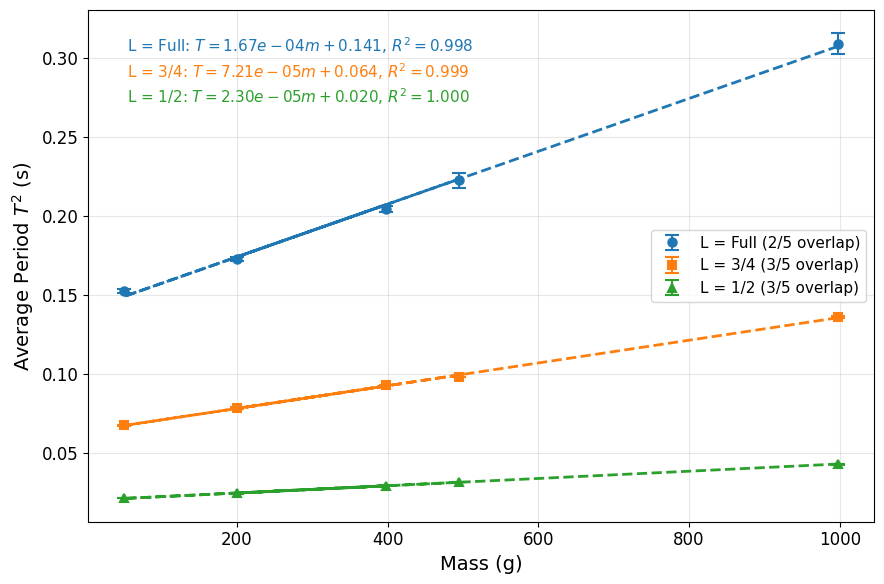

In [12]:
plot_period_vs_mass(df_full, df_three_four, df_half, true_mass_map)


In [13]:
# def calculate_restoring_force(df, amplitude):

#     df = df.copy()
    
#     df['Mass_kg'] = df['Mass'].str.extract(r'm\s*=\s*(\d+)').astype(float)
    
#     df['omega'] = 2 * np.pi / df['Average_Period']
    
#     df['k'] = df['Mass_kg'] * df['omega']**2
    
#     df['Restoring_Force'] = df['k'] * amplitude
    
#     return df[['Mass', 'Average_Period', 'Restoring_Force']]

In [14]:
# Given points
x_vals = np.array([1, 2, 3])
y_vals = K_vals

# Linear regression
A = np.vstack([x_vals, np.ones(len(x_vals))]).T
m, c = np.linalg.lstsq(A, y_vals, rcond=None)[0]
residuals = y_vals - (m*x_vals + c)

# SSR
SSR = np.sum(residuals**2)
variance_y = np.sum((y_vals - np.mean(y_vals))**2)
normalized_SSR = SSR / variance_y

print("Residuals:", residuals)
print("SSR:", SSR)
print("Normalized SSR:", normalized_SSR)

# Threshold example: if normalized SSR > 0.1, consider it far from linear
if normalized_SSR > 0.1:
    print("Points are far from a linear trend.")
else:
    print("Points are close to linear.")

Residuals: [ 142419.75825112 -284839.51650224  142419.75825112]
SSR: 121700325241.84477
Normalized SSR: 0.10026241775718278
Points are far from a linear trend.


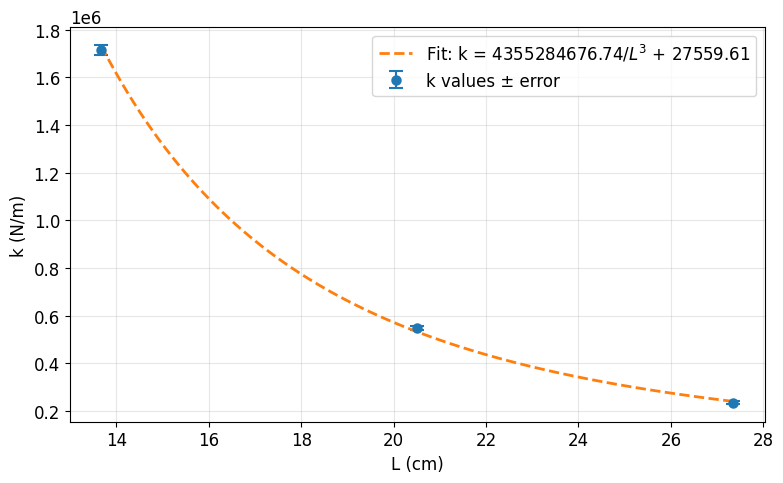

In [37]:
from scipy.optimize import curve_fit

# Example data
# K_vals = [K_full, K_three_four, K_half]
# K_vals_err = [err_full, err_three_four, err_half]

# Reverse order: [1/2, 3/4, Full]
K_vals = np.array(K_vals[::-1])
K_vals_err = np.array(K_vals_err[::-1])
labels = ["L = 1/2", "L = 3/4", "L = Full"]
# x = np.arange(1, len(labels)+1)  # use x = 1,2,3 for fitting
x = np.array([0.5*27.35, 0.75*27.35, 27.35])
# Define x^-3 model
def x_inv3_model(x, a, b):
    return a / x**3 + b

# Fit the model
popt, pcov = curve_fit(
    x_inv3_model, x, K_vals, sigma=K_vals_err,
    absolute_sigma=True, p0=[1e3, np.mean(K_vals)]
)

a_fit, b_fit = popt
K_fit = x_inv3_model(x, a_fit, b_fit)

# Smooth curve for plotting
x_smooth = np.linspace(x.min(), x.max(), 100)
K_smooth = x_inv3_model(x_smooth, a_fit, b_fit)

# Plot
plt.figure(figsize=(8,5))
plt.errorbar(x, K_vals, yerr=K_vals_err, fmt='o', capsize=5, elinewidth=1.5, markeredgewidth=1.5,
             color='tab:blue', label='k values ± error')
plt.plot(x_smooth, K_smooth, '--', color='tab:orange', linewidth=2, label=f'Fit: k = {a_fit:.2f}/$L^3$ + {b_fit:.2f}')

# plt.xticks(x, labels)
plt.xlabel("L (cm)")
plt.ylabel("k (N/m)")
# plt.title("K Values with x⁻³ Fit")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("KvL.pdf")
plt.show()

In [ ]:
# # K values and errors (example arrays, replace with your data)
# K_vals = np.array(K_vals[::-1])        # reversed order if needed
# K_vals_err = np.array(K_vals_err[::-1])

# # Corresponding L values
# L_full = 27.35  # cm
# L_map = {"full": L_full, "3/4": 0.75 * L_full, "1/2": 0.5 * L_full}

# labels = ["L = 1/2", "L = 3/4", "L = Full"]
# L_vals = np.array([L_map["1/2"], L_map["3/4"], L_map["full"]])

# # Define the x^-3 model
# def x_inv3_model(L, a, b):
#     return a / L**3 + b

# # Fit the model
# popt, pcov = curve_fit(x_inv3_model, L_vals, K_vals, sigma=K_vals_err, absolute_sigma=True)
# a_fit, b_fit = popt
# K_fit = x_inv3_model(L_vals, a_fit, b_fit)

# # Smooth curve for plotting
# L_smooth = np.linspace(L_vals.min(), L_vals.max(), 100)
# K_smooth = x_inv3_model(L_smooth, a_fit, b_fit)

# # Plot
# plt.figure(figsize=(8,5))
# plt.errorbar(L_vals, K_vals, yerr=K_vals_err, fmt='o', capsize=5, elinewidth=1.5, markeredgewidth=1.5,
#              color='tab:blue', label='K values ± error')
# plt.plot(L_smooth, K_smooth, '--', color='tab:orange', linewidth=2, 
#          label=f'Fit: K = {a_fit:.2f}/L³ + {b_fit:.2f}')

# plt.xticks(L_vals, labels)
# plt.xlabel("Length L (cm)")
# plt.ylabel("K (N/m)")
# plt.grid(alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
# p_full, cov_full = np.polyfit([true_mass_map[i] for i in df_full["Mass"]], df_full["Average_Period"], 1, cov=True)
# Full length
p_full, cov_full = np.polyfit([true_mass_map[i] for i in df_full["Mass"]], df_full["Average_Period"], 1, cov=True)
b_full, c_full = p_full
b_full_err = np.sqrt(cov_full[0,0])

# 3/4 length
p_3_4, cov_3_4 = np.polyfit([true_mass_map[i] for i in df_full["Mass"]], df_three_four["Average_Period"], 1, cov=True)
b_3_4, c_3_4 = p_3_4
b_3_4_err = np.sqrt(cov_3_4[0,0])

# 1/2 length
p_1_2, cov_1_2 = np.polyfit([true_mass_map[i] for i in df_full["Mass"]], df_half["Average_Period"], 1, cov=True)
b_1_2, c_1_2 = p_1_2
b_1_2_err = np.sqrt(cov_1_2[0,0])

print("Slope uncertainties:")
print("Full length:", b_full_err)
print("3/4 length:", b_3_4_err)
print("1/2 length:", b_1_2_err)